# IFQ619. Module 8 - Exercises

## Uncertainty In Flower Data

You've been contracted by a floral research company in Canada to assist with a dilemma they are facing concerning some uncertainty in their data.

You see, they recently held an expedition to count and characterise flowers in a nearby forest, to inform a local honey company on the yield and quality of flowers for the year. However, some of their papers were damaged during the expedition, causing the species types on certain records to be de-identified, and leaving only the measurements of the flowers behind.

Their management team is upset, considering that the expedition was expensive to fund, and they still need to submit the report to the honey company.

**They want to know if there is some way to confidently determine the flower species of the damaged records?**

## Main Libraries

In [1]:
# You may possibly need to uncomment these lines to install the required libraries

#!pip install pytest
#!pip install pandas_profiling

# For reproduciability reasons:

import numpy as np
import random as rn
import tensorflow as tf
import csv

# Necessary for starting numpy generated random numbers in an initial state

np.random.seed(515)

# Necessary for starting core Python generated random numbers in a state

rn.seed(515)

# Force TensorFlow to single thread

# Multiple threads are a potential source of non-reprocible research results

session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1,
                                          inter_op_parallelism_threads=1 )

# tf.set_random_seed() will make random number generation in the TensorFlow backend
# have a well defined initial state
# more details: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v1.set_random_seed(515)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
#import pandas_profiling
import seaborn as sns
#sns.set_style('dark')
import re
#sns.set(style="ticks", context="talk")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# update for tensorflow

# keras / deep learning libraries

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

# callbacks

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig

plt.style.use('seaborn-deep')
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
# very important for feature transformation
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler


### Aux Functions: Loading Trained Models

In [3]:
# LOAD_MODEL_HISTORY ------------------------------------------
def load_model_history( model_name, path):

    model_hist_loaded = {}
    values = []

    # load dictionary
    r = open( path + model_name + "_hist.csv", "r").read()
    for line in r.split("\n"):
        if(len(line) == 0):
            continue
  
        metric = line.split(",\"[")[0]                                    # extract metrics
        values_str = line.split(",\"[")[1].replace("]\"","").split(", ")  # extract validation values
        values = [float(val_str) for val_str in values_str]
        
        model_hist_loaded.update( {metric : values} )
    return model_hist_loaded

# LOAD_MODEL ------------------------------------------
def load_model( model_name, path ):
    json_file = open( path + model_name +  "_DUO.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    # load weights into new model
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(path + model_name +  "_DUO.h5")
    print("Loaded model from disk")
    return loaded_model

### The Dataset

They provide you with the dataset of the undamaged records. It appears that they were recording the measurements of the flower sizes to indicate the quality of the surveyed flowers. Perhaps we can use this data to inform an analysis that might provide some reassurance under the current uncertainty.

In [4]:


dataset_path = "data/iris.csv"
class_var = "species"
dataset = pd.read_csv( dataset_path )
dataset

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Here we can see the features for which we will be stipulating the classes (however that will come later).

In [5]:
dataset.drop([class_var], axis=1)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Machines cannot understand text and we need to convert these labels to numbers. It is better for the classifier to have one output neuron for each class. This means we will have to transform this data into an M x 3 matrix

In [6]:
pd.DataFrame(dataset[class_var])

,species
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


### Checking Class Balance



Here, we're going to try to detect imbalances in the class labels. A classifier needs to have the same amount of instances for each class, otherwise it will be biased towards one of them

In [7]:
dataset.groupby(class_var).count()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,50,50,50,50
versicolor,50,50,50,50
virginica,50,50,50,50


### Feature Transformation

In [8]:
# separate variables into independent variables and dependent variable

feature_names = dataset.columns.to_list()
feature_names.remove(class_var)
labels = dataset[class_var].unique()

# select features from dataset
X = dataset[feature_names]

# select the class values from dataset
y = dataset[class_var]

# general info about number of features, samples, and classes
n_features =  len(feature_names)
n_samples = len(X)
n_classes = len(y.unique())

print("There are a total of %d training instances, %d features and a total of %d classes\n" %(n_samples, n_features, n_classes))

There are a total of 150 training instances, 4 features and a total of 3 classes



In [9]:
# create numerical encoding for attribute species
# each class will be in one neuron, one column in a matrix
# 'setosa' - index 0
# 'versicolor' - index 1 
# 'virginica' - index 2

enc = OneHotEncoder()

# transform the class variable using OneHot encoder 
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
Y[51:61,:]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [10]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network

scaler = MinMaxScaler()
# transform features using MinMaxScaler
X_scaled = scaler.fit_transform(X)

# taking a look
X_scaled[0:10,:]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

#### Get some data

In [11]:
# Split the data set into training, testing and validation

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state = 9)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=9)


####  Train Model

In [41]:
# create a Neural Network with
# 3 hidden layers
# 12 neurons in each hidden layer
# activation function is ReLu
# output layer uses softmax

model = Sequential()

model.add(Dense(12, input_dim = n_features, activation='relu', name='input'))

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))

model.add(Dense(n_classes, activation='softmax'))



In [42]:
# compile the model with 
# loss function = categorical_crossentropy
# optimization function - nadam
# metrics - accuracy

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 12)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_6 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 39        
Total params: 567
Trainable params: 567
Non-trainable params: 0
_________________________________________________________________


In [44]:
# fit model to data

early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')
callbacks_list = [early_stop]

history_callback = model.fit(X_train, Y_train, batch_size = 12, epochs = 150,
                                 verbose=1, validation_data=(X_validation, Y_validation), callbacks=callbacks_list)
    



Train on 105 samples, validate on 22 samples
Epoch 1/150
105/105 [==============================] - 1s 5ms/sample - loss: 1.0963 - accuracy: 0.4286 - val_loss: 1.0964 - val_accuracy: 0.3636
Epoch 2/150
105/105 [==============================] - 0s 352us/sample - loss: 1.0861 - accuracy: 0.5524 - val_loss: 1.0873 - val_accuracy: 0.3182
Epoch 3/150
105/105 [==============================] - 0s 372us/sample - loss: 1.0745 - accuracy: 0.5810 - val_loss: 1.0709 - val_accuracy: 0.3182
Epoch 4/150
105/105 [==============================] - 0s 372us/sample - loss: 1.0589 - accuracy: 0.6000 - val_loss: 1.0539 - val_accuracy: 0.5000
Epoch 5/150
105/105 [==============================] - 0s 352us/sample - loss: 1.0422 - accuracy: 0.6286 - val_loss: 1.0370 - val_accuracy: 0.4545
Epoch 6/150
105/105 [==============================] - 0s 362us/sample - loss: 1.0249 - accuracy: 0.6286 - val_loss: 1.0178 - val_accuracy: 0.4091
Epoch 7/150
105/105 [==============================] - 0s 381us/sample - lo

#### Evaluate Model

In [45]:
# evaluate model performance in training data
train_loss,train_acc= model.evaluate(X_train, Y_train)

# evaluate model performance in test data
test_loss,test_acc = model.evaluate(X_test, Y_test)

print('[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))


23/23 [==============================] - 0s 130us/sample - loss: 0.0271 - accuracy: 1.0000
[Accuracy] Train: 0.981, Test: 1.000
[Loss] Train: 0.062, Test: 0.027


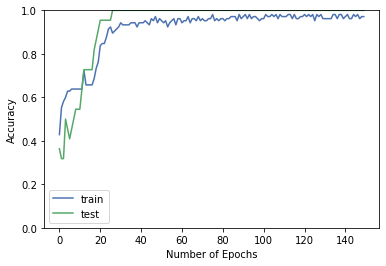

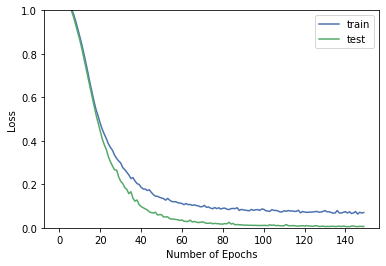

In [46]:
# get model's training history
plt.plot(history_callback.history['accuracy'], label='train')
plt.plot(history_callback.history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.plot(history_callback.history['loss'], label='train')
plt.plot(history_callback.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Generating Explanations



In [17]:
import lime
from lime import lime_tabular

ModuleNotFoundError: No module named 'lime'

In [ ]:
feature_names = dataset.columns.to_list()
feature_names.remove(class_var)


In [ ]:
# the dataset does not have many features
# let's use all of them
MAX_FEAT = len(feature_names)

In [ ]:
# Calling LIME's explainer for Tabular data
explainer = 


In [ ]:
# instance to be explained
flower_indx = 0

flower_feat = X_scaled[flower_indx,:]
flower_true_pred = enc.inverse_transform(np.expand_dims(Y[flower_indx,:], 0))[0][0]

print("Flower id: %d \t Groundtruth Label: %s\n" %(flower_indx, flower_true_pred))


#### Generating Lime Explanations

In [ ]:
# explain instance using lime
exp = 
exp.show_in_notebook(show_table=True)

In [ ]:
fig = exp_good.as_pyplot_figure(label=labels.tolist().index(pred_good))

### Generating Many Lime Explanations


In [ ]:
%matplotlib notebook

for flower_indx in range(0, len(X_test)):
    
    flower_feat = X_test[flower_indx,:]
    flower_true_pred = enc.inverse_transform(np.expand_dims(Y_test[flower_indx,:], 0))[0][0]
    
    pred_good = best_model_loaded.predict(np.expand_dims(flower_feat, 0))
    pred_good = enc.inverse_transform( pred_good )[0][0]

    # explain instance using a good model
    exp_good = explainer.explain_instance(flower_feat, best_model_loaded.predict, num_features= MAX_FEAT, 
                                 labels=[labels.tolist().index(pred_good)])
    
    exp_good.show_in_notebook(show_table=True)
    exp_good.as_pyplot_figure(label=labels.tolist().index(pred_good),)
    print("---------------------------------------------------------------")
    
